In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 0.) Clean the Apple Data to get a quarterly series of EPS.

In [2]:
y = pd.read_csv("AAPL_quarterly_financials.csv")

In [3]:
y.index = y.name

In [4]:
y = pd.DataFrame(y.loc["BasicEPS", :'03/31/2004']).iloc[2:, :]

In [5]:
y.index = pd.to_datetime(y.index)

In [6]:
y = y.sort_index().fillna(0.)

# 1.) Come up with 6 search terms you think could nowcast earnings. (Different than the ones I used) Add in 3 terms that that you think will not Nowcast earnings. Pull in the gtrends data. Clean it to have a quarterly average.

In [7]:
from pytrends.request import TrendReq

In [8]:
# Create pytrends object
pytrends = TrendReq(hl='en-US', tz=360) # hl means language, tz is time zone.

# Set up the keywords and the timeframe
keywords = ['iphone','Recession','New iPhone','Interest rate','Samsung','Hospital']  # Add your keywords here
# Add your keywords here
start_date = '2004-03-31'
end_date = '2023-09-30'

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Iterate through keywords and fetch data
for keyword in keywords:
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    df[keyword] = interest_over_time_df[keyword]

In [9]:
X = df.resample("Q").mean()
# W : weekly frequency
# M : month end frequency
# SM : semi-month end frequency (15th and end of month)
# Q : quarter end frequency

In [10]:
temp = pd.concat([y, X], axis=1).dropna() # combine y and x on columns
y = temp[["BasicEPS"]].copy()
x = temp.iloc[:, 1:].copy()

# 2.) Normalize all the X data

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [12]:
X_scaled = scaler.fit_transform(x)

# 3.) Import data. Train, Test, Holdout (80%,15%,5%)

In [13]:
train_data, temp_data = train_test_split(X, test_size=0.2, random_state=42)
test_data, holdout_data = train_test_split(temp_data, test_size=0.25, random_state=42)

# 4.) Run a Lasso with lambda of .5. Plot a bar chart.

In [14]:
from sklearn.linear_model import Lasso

In [15]:
lasso = Lasso(alpha = .1)

In [16]:
lasso.fit(X_scaled, y)

Lasso(alpha=0.1)

In [17]:
print(lasso.coef_)

[ 0.1391939  -0.          0.          0.26701804  0.          0.        ]


In [18]:
coefficients = lasso.coef_

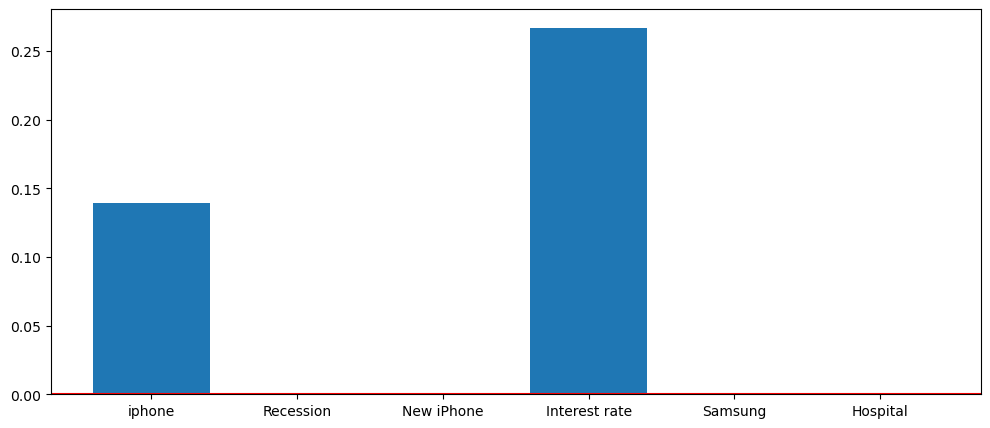

In [19]:
plt.figure(figsize = (12, 5))
plt.bar(range(len(coefficients)), coefficients, tick_label=X.columns)
plt.axhline(0, color = "red")
plt.show()

# 5.) Do these coefficient magnitudes make sense?

All coefficient is 0 under alpha=.5 so the result is derived from alpha=.1 to have non-zero result.

It seems like interest rate do have a high influence on the earnings per share.

# 6.) Run a for loop looking at 10 different Lambdas and plot the coefficient magnitude for each.

# 7.) Run a cross validation. What is your ideal lambda?